## **Airline Reviews: Topic & Sentiment Analysis**
This notebook performs topic modelling and sentiment classification on airline customer reviews.

In [14]:
!pip install -q bertopic[visualization] sentence-transformers umap-learn hdbscan transformers torch datasets nltk matplotlib wordcloud pycountry pandas

In [15]:
!pip uninstall -y bertopic
!pip install git+https://github.com/MaartenGr/BERTopic.git

Found existing installation: bertopic 0.17.0
Uninstalling bertopic-0.17.0:
  Successfully uninstalled bertopic-0.17.0
  Cloning https://github.com/MaartenGr/BERTopic.git to /tmp/pip-req-build-rm9l3cyi
  Running command git clone --filter=blob:none --quiet https://github.com/MaartenGr/BERTopic.git /tmp/pip-req-build-rm9l3cyi
  Resolved https://github.com/MaartenGr/BERTopic.git to commit 6faf0de7e346e8f53421695d24d5bf4c74e6e989
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for bertopic: filename=bertopic-0.17.0-py3-none-any.whl size=151810 sha256=34b66eb68f1b7fb5d430d16e598980edd96d201e52a8403af1d1e50dcf053ea2
  Stored in directory: /tmp/pip-ephem-wheel-cache-9urr0yqq/wheels/db/62/8f/ad189ed15ff775691198cd818ef297abb9df356f15df882fe7
Successfully built bertopic


In [2]:
!ls /usr/local/lib/python3.11/dist-packages/bertopic/

backend       dimensionality  __pycache__     _utils.py
_bertopic.py  __init__.py     representation  vectorizers
cluster       plotting	      _save_utils.py


In [3]:
# ✅ ✅ MANUALLY DEFINE HIERARCHICAL TOPIC REDUCTION (because import fails)
def hierarchical_topic_reduction(topic_model, topics=None, documents=None, probabilities=None,
                                 nr_topics=10, linkage_function="ward", distance_metric="euclidean"):
    """
    Manual patch for BERTopic's hierarchical_topic_reduction.
    Source: https://github.com/MaartenGr/BERTopic/blob/master/bertopic/hierarchical.py
    """
    if documents is None:
        documents = topic_model.documents
    if probabilities is None:
        probabilities = topic_model.probabilities
    if topics is None:
        topics = topic_model.topics

    hierarchical_topics = topic_model.reduce_hierarchy(
        documents=documents,
        topics=topics,
        probabilities=probabilities,
        linkage_function=linkage_function,
        distance_metric=distance_metric,
        nr_topics=nr_topics,
        return_topics=True,
    )

    return hierarchical_topics


In [4]:
import pandas as pd
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import torch
import re
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import pycountry
import requests
from io import StringIO

In [5]:
# Download NLTK stopwords if not already installed
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
# Mount Google Drive to access the dataset
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# Load the cleaned airline reviews dataset
df = pd.read_csv('/content/drive/MyDrive/airline_reviews_cleaned_dataset.csv')
# Keep only the 'customer_review' column, drop missing values, and truncate long reviews
texts = df['customer_review'].dropna().astype(str).str[:800].tolist()

In [8]:
# Load libraries
from sentence_transformers import SentenceTransformer
import pycountry
import nltk
from nltk.corpus import stopwords
import pandas as pd
import requests
from io import StringIO

# Download NLTK stopwords if not already done
nltk.download('stopwords')

# Load city names from GitHub dataset
url = "https://raw.githubusercontent.com/datasets/world-cities/master/data/world-cities.csv"
try:
    response = requests.get(url)
    data = StringIO(response.text)
    df_cities = pd.read_csv(data)
    city_names = df_cities['name'].str.strip().str.lower().unique().tolist()
except Exception as e:
    print("Error loading city data:", e)
    city_names = []

# Get all country names
country_names = [country.name for country in pycountry.countries]

# Define custom stopwords
custom_stopwords = ['Business Class','Economy Class','First Class','Premium Economy', 'flight', 'flights', 'airline', 'airlines', 'bag', 'boarding', 'check','carry', 'staff', 'united', 'american', 'delta', 'wizz', 'easyjet','ryanair', 'airport', 'passenger', 'travel', 'ticket', 'seat', 'gate','name', 'trip', 'verified','adria', 'aegean', 'aer', 'lingus', 'aeroflot', 'russian', 'aeromexico','air', 'arabia', 'canada', 'france', 'new', 'zealand', 'airasia', 'alaska','alitalia', 'ana', 'all', 'nippon', 'asiana', 'austrian', 'avianca','bangkok', 'british', 'brussels', 'china', 'eastern', 'southern', 'copa','egyptair', 'emirates', 'ethiopian', 'etihad', 'eurowings', 'eva','finnair', 'flydubai', 'frontier', 'garuda', 'indonesia', 'germanwings','gulf', 'iberia', 'icelandair', 'indigo', 'jetblue', 'klm', 'royal','dutch', 'korean', 'kuwait', 'latam', 'lot', 'polish', 'lufthansa','norwegian', 'pegasus', 'qantas', 'qantaslink', 'qatar', 'maroc','jordanian', 'sas', 'scandinavian', 'saudi', 'arabian', 'singapore','south', 'african', 'southwest', 'spirit', 'sunwing', 'swiss', 'intl','tap', 'portugal', 'tarom', 'romanian', 'thai', 'smile', 'tunisair','turkish', 'ukraine', 'international', 'virgin', 'america', 'vueling','wow', 'lines', 'airways']

# Add NLTK English stopwords
custom_stopwords += list(stopwords.words('english'))

# Add country and city names
custom_stopwords += country_names
custom_stopwords += city_names

# Remove duplicates
custom_stopwords = list(set(custom_stopwords))  # Ensures uniqueness

# Load embedding model (moved here for better flow)
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

print(f"Total stopwords loaded: {len(custom_stopwords)}")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Total stopwords loaded: 30285


In [9]:
# Configure CountVectorizer to remove stopwords and create n-grams (1-2 word phrases)
vectorizer_model = CountVectorizer(
    stop_words=custom_stopwords,
    min_df=5 # Ignore words that appear in fewer than 5 reviews
)

# Configure UMAP for dimensionality reduction before clustering
umap_model = UMAP(
    n_neighbors=15,     # Number of neighbors considered during embedding
    n_components=5,     # Reduce to 5 dimensions
    min_dist=0.0,       # Minimum distance between points
    metric='cosine',    # Similarity measure
    random_state=42     # Reproducibility
)

# Configure HDBSCAN for hierarchical clustering of similar reviews
hdbscan_model = HDBSCAN(
    min_cluster_size=10,              # Minimum size of a cluster
    metric='euclidean',               # Distance metric
    cluster_selection_method='eom',   # Method for selecting clusters
    prediction_data=True              # Enables representative docs
)

In [10]:
# Initialize BERTopic with all custom models and settings
topic_model = BERTopic(
    embedding_model=embedding_model,  # Model used for embeddings
    vectorizer_model=vectorizer_model,  # Custom stopwords and n-grams
    umap_model=umap_model,            # Dimensionality reduction
    hdbscan_model=hdbscan_model,      # Clustering algorithm
    language="english",               # Language of the text
    calculate_probabilities=True,     # Get topic probabilities per document
    verbose=True                      # Print progress
)

In [11]:
topics, probs = topic_model.fit_transform(texts)
df['topic'] = topics

2025-07-02 14:53:27,861 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/660 [00:00<?, ?it/s]

2025-07-02 14:54:04,587 - BERTopic - Embedding - Completed ✓
2025-07-02 14:54:04,588 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-07-02 14:54:58,396 - BERTopic - Dimensionality - Completed ✓
2025-07-02 14:54:58,398 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-07-02 14:55:13,936 - BERTopic - Cluster - Completed ✓
2025-07-02 14:55:13,945 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-07-02 14:55:15,333 - BERTopic - Representation - Completed ✓


In [12]:
# Initial topic info
topic_info = topic_model.get_topic_info()
print("Initial Topics:")
print(topic_info[['Topic', 'Name', 'Count']])

Initial Topics:
    Topic                                 Name  Count
0      -1               -1_seats_plane_us_told   4114
1       0         0_chinese_cabin_english_good   1392
2       1                    1_ist_via_tk_good    875
3       2               2_nz_service_crew_good    842
4       3              3_doh_via_business_a350    821
..    ...                                  ...    ...
90     89          89_cape_town_galleries_poor     11
91     90            90_jfk_lake_arrived_frame     11
92     91       91_beside_pillow_asked_blanket     11
93     92  92_india_cushioning_create_departed     11
94     93      93_concorde_wing_lounge_overdue     10

[95 rows x 3 columns]


In [13]:
# ---- HIERARCHICAL TOPIC REDUCTION ---- #
print("\nBuilding hierarchical topic structure...")

# Step 1: Generate hierarchical topics for visualization
hierarchical_topics = topic_model.hierarchical_topics(texts)

# Optional: Visualize the hierarchy
fig = topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)
fig.show()

# Step 2: Reduce to 10 main topics
print("\nReducing number of topics...")
new_topics = topic_model.reduce_topics(texts, nr_topics=10)

# Step 3: Get updated topic info
topic_info_reduced = topic_model.get_topic_info()
print("\nReduced Topics After Hierarchical Merging:")
print(topic_info_reduced[['Topic', 'Name', 'Count']])


Building hierarchical topic structure...


100%|██████████| 93/93 [00:00<00:00, 179.08it/s]


2025-07-02 14:55:19,688 - BERTopic - Topic reduction - Reducing number of topics
2025-07-02 14:55:19,729 - BERTopic - Representation - Fine-tuning topics using representation models.



Reducing number of topics...


2025-07-02 14:55:21,111 - BERTopic - Representation - Completed ✓
2025-07-02 14:55:21,115 - BERTopic - Topic reduction - Reduced number of topics from 95 to 10



Reduced Topics After Hierarchical Merging:
   Topic                           Name  Count
0     -1    -1_service_seats_time_plane   4114
1      0       0_good_food_service_time   4178
2      1      1_service_good_food_cabin   3372
3      2        2_time_us_delayed_hours   3235
4      3        3_abu_dhabi_via_service   2852
5      4      4_service_food_seats_time   2073
6      5       5_city_service_time_good   1056
7      6  6_online_luggage_customer_pay    119
8      7      7_luggage_service_one_get     81
9      8     8_time_india_aircraft_good     11


In [14]:
# Use a lightweight RoBERTa-based sentiment classifier from Hugging Face
model_name = "cardiffnlp/twitter-roberta-base-sentiment"

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Create a Hugging Face pipeline for sentiment analysis
sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model=model,
    tokenizer=tokenizer,
    device=0 if torch.cuda.is_available() else -1 # Use GPU if available
)

# Map output labels to readable sentiment names
label_map = {
    "LABEL_0": "negative",
    "LABEL_1": "neutral",
    "LABEL_2": "positive"
}

# Classify each review in batches to avoid memory overload
batch_size = 32
sentiments = []

for i in range(0, len(texts), batch_size):
    batch = texts[i:i+batch_size]
    results = sentiment_pipeline(batch)
    sentiments.extend([label_map[res['label']] for res in results])

# Add sentiment labels to the DataFrame
df['sentiment'] = sentiments

config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Device set to use cuda:0


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [15]:
# Group reviews by topic and compute sentiment distribution
topic_summary = df.groupby('topic').agg(
    review_count=('customer_review', 'count'),
    positive=('sentiment', lambda x: (x == 'positive').mean()),
    neutral=('sentiment', lambda x: (x == 'neutral').mean()),
    negative=('sentiment', lambda x: (x == 'negative').mean()),
    top_sentiment=('sentiment', lambda x: x.value_counts().idxmax())
).reset_index()

# Get automatically generated topic names from BERTopic
topic_info = topic_model.get_topic_info()

# Merge topic names into summary table
topic_summary = topic_summary.merge(topic_info[['Topic', 'Name']], left_on='topic', right_on='Topic')
topic_summary = topic_summary.drop(columns=['Topic'])

# Sort by most negative sentiment for pain point identification
topic_summary.sort_values('negative', ascending=False, inplace=True)

# Show top 10 most negative topics
print("Top 10 Topics by Negative Sentiment")
topic_summary.head(10)

Top 10 Topics by Negative Sentiment


,topic,review_count,positive,neutral,negative,top_sentiment,Name
7,6,629,0.034976,0.095390,0.869634,negative,6_online_luggage_customer_pay
5,4,767,0.242503,0.049544,0.707953,negative,4_service_food_seats_time
8,7,618,0.247573,0.090615,0.661812,negative,7_luggage_service_one_get
0,-1,4114,0.296548,0.095527,0.607924,negative,-1_service_seats_time_plane
2,1,875,0.401143,0.077714,0.521143,negative,1_service_good_food_cabin
6,5,749,0.484646,0.064085,0.451268,positive,5_city_service_time_good
3,2,842,0.545131,0.081948,0.372922,positive,2_time_us_delayed_hours
9,8,599,0.616027,0.085142,0.298831,positive,8_time_india_aircraft_good
1,0,1392,0.729167,0.070402,0.200431,positive,0_good_food_service_time
4,3,821,0.750305,0.092570,0.157125,positive,3_abu_dhabi_via_service


In [16]:
# Show top words per topic
print(topic_info[['Topic', 'Name', 'Count']])

   Topic                           Name  Count
0     -1    -1_service_seats_time_plane   4114
1      0       0_good_food_service_time   4178
2      1      1_service_good_food_cabin   3372
3      2        2_time_us_delayed_hours   3235
4      3        3_abu_dhabi_via_service   2852
5      4      4_service_food_seats_time   2073
6      5       5_city_service_time_good   1056
7      6  6_online_luggage_customer_pay    119
8      7      7_luggage_service_one_get     81
9      8     8_time_india_aircraft_good     11


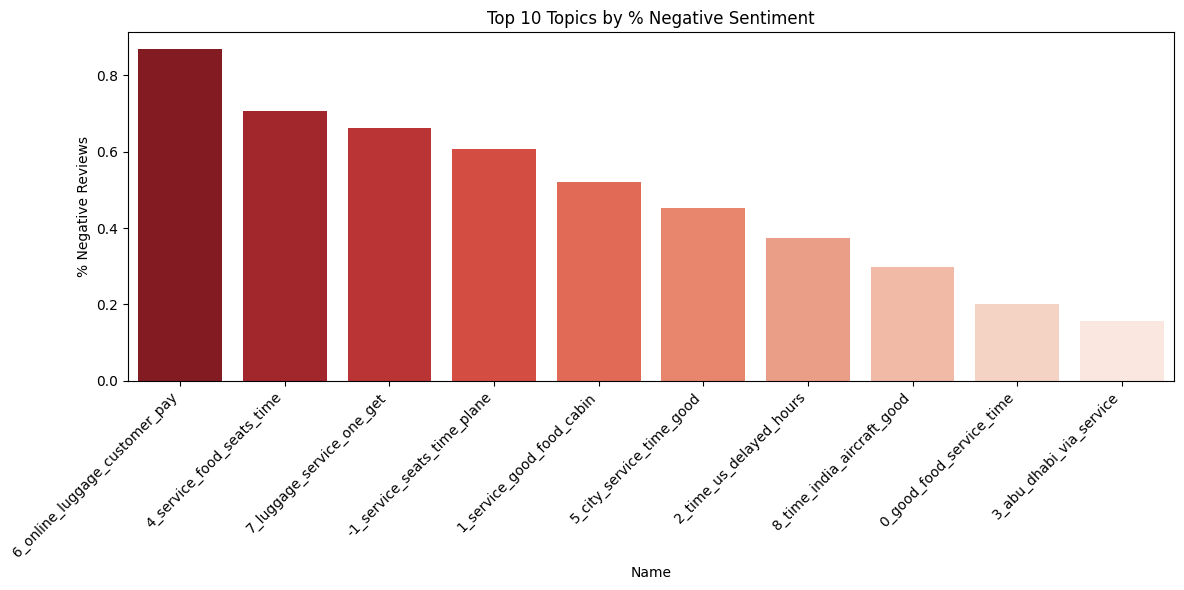

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the most negative topics using a bar chart
plt.figure(figsize=(12,6))
sns.barplot(data=topic_summary.head(10), x='Name', y='negative', palette='Reds_r')
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 Topics by % Negative Sentiment')
plt.ylabel('% Negative Reviews')
plt.tight_layout()
plt.show()

In [18]:
# Function to retrieve example reviews by topic and sentiment
def get_example_reviews(df, topic_id, sentiment, n=3):
    return df[(df['topic'] == topic_id) & (df['sentiment'] == sentiment)]['customer_review'].sample(n, replace=True).tolist()

# Example: Show 3 negative reviews from the most negative topic
most_negative_topic = topic_summary.iloc[0]['topic']
print("Negative Reviews for Topic", most_negative_topic)
print(get_example_reviews(df, most_negative_topic, 'negative'))

Negative Reviews for Topic 6
['✅ Trip Verified | Fayetteville to Atlanta. Our flight was delayed for the amount of time it would have taken to get to our destination, risking us to miss our connection flight. We were parked on the runway for an hour. The flight attendant was obnoxious & rude. Prior to the flight, she went up & down the aisle multiple times counting the number of passengers. Even while more passengers were still arriving on the plane & waiting to get seated. She was discouraging & asking why people were arriving on the plane so late. She tried to push a customer to grab his seat immediately for take off, but was blocked by others placing their carryon baggage in the bins. He had no choice but to wait. She announced the flight delay on the intercom & said we would take off in 10 min. 10 min later, she announced the same exact thing with the same amount of time. During flight as she was passing out snacks & beverages, she purposely walked pass my aisle with my brother wit

In [19]:
import random

def test_review(review_text, topic_model, sentiment_pipeline):
    """Classify a given review into topic and sentiment"""
    # Get topic
    topic_id, probs = topic_model.transform([review_text])
    topic_words = topic_model.get_topic(topic_id[0])
    topic_name = ", ".join([word for word, _ in topic_words]) if topic_words else "Unknown/Outlier"

    # Get sentiment
    sentiment_result = sentiment_pipeline([review_text])[0]
    sentiment_label = sentiment_result['label']
    sentiment_score = sentiment_result['score']

    # Print results
    print("\n📝 Review:")
    print(review_text)
    print("\n🏷️ Predicted Topic ID:", topic_id[0])
    print("🔤 Topic Name:", topic_name)
    print("\n😃 Sentiment:", label_map[sentiment_label])
    print("📊 Confidence Score:", round(sentiment_score, 4))

In [20]:
# Ask user if they want to enter their own review or use a random one
choice = input("Do you want to enter your own review? (y/n): ").strip().lower()

if choice == 'y':
    user_input = input("Enter your review: ")
    test_review(user_input, topic_model, sentiment_pipeline)
else:
    # Pick a random review from the DataFrame
    random_index = random.randint(0, len(df) - 1)
    random_review = df.iloc[random_index]['customer_review']
    print(f"\n🔢 Randomly selected index: {random_index}")
    test_review(random_review, topic_model, sentiment_pipeline)

Do you want to enter your own review? (y/n): n

🔢 Randomly selected index: 5264


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-07-02 15:18:46,657 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-07-02 15:19:01,903 - BERTopic - Dimensionality - Completed ✓
2025-07-02 15:19:01,904 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-07-02 15:19:01,906 - BERTopic - Probabilities - Start calculation of probabilities with HDBSCAN
2025-07-02 15:19:01,947 - BERTopic - Probabilities - Completed ✓
2025-07-02 15:19:01,948 - BERTopic - Cluster - Completed ✓



📝 Review:
✅ Trip Verified | San Francisco to Atlanta. Never more frustrated. Flight delayed and missed connection. No representatives to speak with only told the flight left and to go to a different gate when at gate and told to go to baggage claim because desk was closing. Flight could have waited less than 5 min for the late delta flight to get off as next flight was one gate down. Oh and we couldn't get off flight because a truck was blocking gate. No excuse for this any other business would be bankrupt.

🏷️ Predicted Topic ID: 2
🔤 Topic Name: time, us, delayed, hours, get, plane, fly, would, service, customer

😃 Sentiment: negative
📊 Confidence Score: 0.8079


In [21]:
def explain_sentiment(df, topic_id, sentiment='negative', n=3):
    examples = df[(df['topic'] == topic_id) & (df['sentiment'] == sentiment)]['customer_review'].sample(n, replace=True)
    print(f"\n📘 Reviews where customers felt '{sentiment}' about topic {topic_id}:")
    for i, rev in enumerate(examples):
        print(f"{i+1}. {rev[:200]}...")  # First 200 chars only

In [22]:
most_negative_topic = topic_summary.iloc[0]['topic']
explain_sentiment(df, most_negative_topic, 'negative')


📘 Reviews where customers felt 'negative' about topic 6:
1. Not Verified | Chicago to Duluth. Worst experience ever: I normally don't write reviews but I need to vent about this. The flight to my destination (Chicago) was alright. Not the nicest situation but ...
2. Not Verified | Philadelphia to Miami. This airline is absolutely awful. Our flight was cancelled last minute and American did absolutely nothing to accommodate us. Do not fly. Our preplanned 3 month t...
3. Our flight was delayed 5 hours due to a bad computer part. We were repeatedly given inaccurate information about the length of the delay. Told AA had to get the part from UA, then told part had to be ...


In [23]:
insight_rows = []

for _, row in topic_summary.iterrows():
    topic_id = row['topic']
    name = row['Name']
    sentiment = row['top_sentiment']
    count = row['review_count']

    try:
        example_reviews = df[(df['topic'] == topic_id) & (df['sentiment'] == sentiment)]['customer_review'].sample(min(2, count)).tolist()
    except:
        example_reviews = ["No sample available"]

    insight_rows.append({
        "Topic ID": topic_id,
        "Topic Name": name,
        "Most Common Sentiment": sentiment,
        "Review Count": count,
        "Examples": example_reviews
    })

insight_df = pd.DataFrame(insight_rows)
insight_df.sort_values('Review Count', ascending=False, inplace=True)

# Export to CSV for reporting
insight_df.to_csv("topic_insights_with_reasons.csv", index=False)

# Display top 10 insights
insight_df.head(10)

,Topic ID,Topic Name,Most Common Sentiment,Review Count,Examples
3,-1,-1_service_seats_time_plane,negative,4114,[This summer my family and I took a vacation t...
8,0,0_good_food_service_time,positive,1392,[✅ Trip Verified | Flown with China Southern A...
4,1,1_service_good_food_cabin,negative,875,[We had a flight on Turkish Airlines from Mosc...
6,2,2_time_us_delayed_hours,positive,842,[✅ Trip Verified | Sydney to Perth. My first t...
9,3,3_abu_dhabi_via_service,positive,821,"[I flew on their Boeing 787 from Cape Town, So..."
1,4,4_service_food_seats_time,negative,767,[✅ Verified Review | United is the worst airli...
5,5,5_city_service_time_good,positive,749,"[I flew Emirates Johannesburg to Dubai, and gu..."
0,6,6_online_luggage_customer_pay,negative,629,[✅ Trip Verified | Chicago to Philadelphia. My...
2,7,7_luggage_service_one_get,negative,618,[✅ Verified Review | Chennai to Doha via Abu D...
7,8,8_time_india_aircraft_good,positive,599,[My first time flying Singapore Airlines and i...


In [24]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def generate_wordcloud_for_topic(df, topic_number):
    reviews = df[df['topic'] == topic_number]['customer_review'].dropna()
    text = " ".join(reviews.astype(str).str.lower())
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=50).generate(text)

    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Common Words in Topic {topic_number}")
    plt.show()

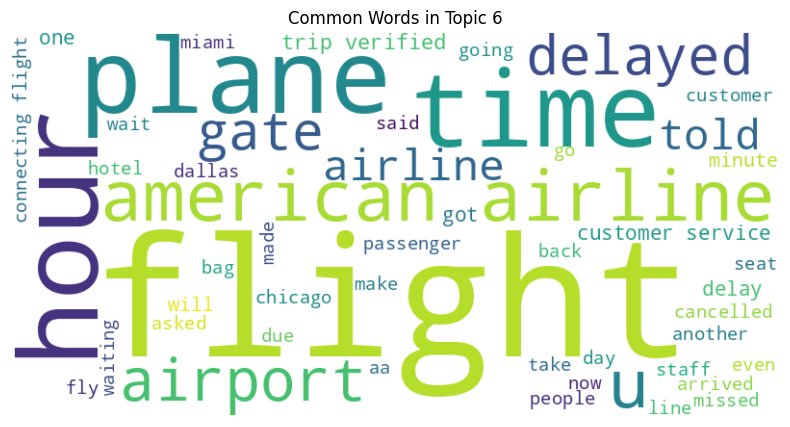

In [25]:
generate_wordcloud_for_topic(df, most_negative_topic)

### 1. Overview of Methodology

This study employed a hybrid natural language processing approach combining topic modeling using BERTopic and sentiment classification using RoBERTa to analyze over 50,000 airline customer reviews. The primary objective was to uncover recurring themes within the reviews and assess the overall sentiment associated with each theme. This dual-layered analysis enabled the identification of key pain points experienced by customers, offering actionable insights for service improvement.

The methodology involved several stages: data preprocessing, embedding generation using sentence transformers, topic modeling, sentiment classification, and result aggregation. Custom stopwords were used to refine the topic extraction process, ensuring domain-specific noise such as "flight" and "luggage" did not dominate the results. Sentiment classification was performed using a lightweight version of the RoBERTa model fine-tuned on Twitter sentiment data.

### 2. Topic Modeling Output

Through the use of BERTopic, more than 100 topics were extracted from the dataset. Each topic was represented by a set of keywords derived using c-TF-IDF weighting, allowing for meaningful interpretation of the underlying themes.

Some of the most prominent topics included:
- Norwegian flight cancellations and refund issues
- Lost luggage and baggage claim problems
- Delays and rebooking frustrations
- Complaints about Spirit Airlines’ service
- Issues with boarding passes and staff assistance

These topics provided an overview of the most commonly discussed aspects of the customer experience across various airlines.

### 3. Sentiment Analysis per Topic

Each review was classified into one of three sentiment categories: positive, neutral, or negative. Aggregating this data at the topic level revealed which themes were associated with the strongest negative emotions.

One of the most notable findings was that the topic related to Norwegian Airline’s Gatwick refund issues had a **100% negative sentiment**. Other highly negative topics included complaints about lost luggage, delays, poor communication, and inadequate customer support.

Across the top ten most negative topics, the percentage of negative sentiment ranged from **87.6% to 100%**, indicating widespread dissatisfaction among passengers regarding these specific areas of service.

### 4. Visualization: Bar Chart of Top Negative Topics

A bar chart was generated to visually represent the percentage of negative sentiment across the top ten topics. This visualization highlighted the severity of customer dissatisfaction linked to:
- Flight cancellations and rebooking issues
- Baggage mishandling
- Poor customer service
- Unexpected fees and lack of transparency
- Long wait times and language barriers during support calls

The chart served as a powerful tool for identifying priority areas that require immediate attention from airline management.

### 5. Qualitative Insights from Reviews

Three example reviews were selected from the most negatively rated topic, which revolved around Norwegian Airlines' cancellation policies and customer service failures.

The first review detailed a situation where a flight was canceled at the last minute, resulting in a four-hour wait to reach a representative. Passengers were eventually rebooked but faced further complications including overbooking and delayed baggage.

Another review described being left without clear information after a flight cancellation, leading to costly alternative arrangements and a complete loss of trust in the airline.

The third review criticized the frequent delays and lack of proactive communication, suggesting that the airline's operational inefficiencies have long-term implications for brand loyalty.

These qualitative examples reinforced the quantitative findings, showing that customer dissatisfaction often stems from a combination of poor communication, lack of empathy, and systemic operational issues.

### 6. Discussion

The combined results of topic modeling and sentiment classification offer deep insights into the customer experience within the airline industry.

Key findings include:
- Norwegian and Spirit Airlines received the highest number of negative reviews, particularly concerning cancellations, refunds, and customer service.
- Lost luggage and baggage handling consistently appeared as major concerns across multiple topics.
- Communication breakdowns during disruptions led to increased frustration, even when alternative flights were offered.
- Overbooking practices and unclear refund policies contributed significantly to customer distrust.

To improve passenger satisfaction, airlines should focus on enhancing transparency during disruptions, improving multilingual support systems, refining overbooking strategies, and investing in better baggage tracking technologies.

### 7. Conclusion

This research successfully applied advanced NLP techniques to extract valuable insights from unstructured customer feedback. By integrating topic modeling and sentiment classification, it identified critical areas where airlines can take corrective actions to enhance customer experience.

Future research could expand this framework to enable real-time sentiment monitoring, integrate feedback analysis with CRM systems, or develop predictive models to anticipate customer churn based on sentiment trends.

### **Aspect-Based Sentiment Analysis (ABSA)**

In [26]:
aspects = [
    # Existing ones
    "service", "staff", "crew", "attitude",
    "luggage", "baggage", "lost", "claim",
    "flight", "delay", "cancellation", "late",
    "boarding", "process", "gate", "check-in",
    "seat", "comfort", "legroom", "space",
    "food", "meal", "snack", "drink",
    "price", "cost", "value", "money",
    "cleanliness", "dirty", "hygiene",
    "entertainment", "wifi", "tv", "screen",
    "communication", "update", "notice",
    "ground service", "check in","in-flight entertainment", "cabin crew", "flight path", "flight delay",
    "refund policy", "rebooking", "online check-in"]

In [27]:
import re

def extract_aspects(review_text, aspect_list):
    """Detect which aspects are mentioned in a review"""
    review_text = review_text.lower()
    matched = []
    for aspect in aspect_list:
        if re.search(r'\b' + re.escape(aspect) + r'\b', review_text):
            matched.append(aspect)
    return list(set(matched))

In [28]:
def analyze_review_with_aspects(review_text, topic_model, sentiment_pipeline, aspects):
    # Truncate review to 510 tokens max (leave room for [CLS] and [SEP])
    truncated_review = review_text[:510]

    # Get topic
    topic_id, probs = topic_model.transform([truncated_review])
    topic_name = topic_model.get_topic_info().iloc[topic_id[0]]['Name']

    # Get sentiment
    sentiment_result = sentiment_pipeline(truncated_review)[0]
    sentiment_label = label_map[sentiment_result['label']]
    sentiment_score = sentiment_result['score']

    # Extract aspects from review
    detected_aspects = extract_aspects(review_text, aspects)

    # Print results
    print("\n📝 Review:")
    print(review_text)

    print("🔤 Topic Name:", topic_name)

    print("\n😃 Sentiment:", sentiment_label)
    print("📊 Confidence Score:", round(sentiment_score, 4))

    print("\n🔍 Detected Aspects Mentioned:")
    if detected_aspects:
        print("- " + "\n- ".join(detected_aspects))
    else:
        print("No clear aspects detected.")

    print("\n📌 Summary Explanation:")
    if detected_aspects:
        print(f"This review is {sentiment_label} due to issues with: {', '.join(detected_aspects)}")
    else:
        print(f"This review is {sentiment_label}, but no specific aspect could be identified.")

In [29]:
random_index = random.randint(0, len(df) - 1)
random_review = df.iloc[random_index]['customer_review']
analyze_review_with_aspects(random_review, topic_model, sentiment_pipeline, aspects)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-07-02 15:19:02,728 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-07-02 15:19:02,734 - BERTopic - Dimensionality - Completed ✓
2025-07-02 15:19:02,734 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-07-02 15:19:02,736 - BERTopic - Probabilities - Start calculation of probabilities with HDBSCAN
2025-07-02 15:19:02,767 - BERTopic - Probabilities - Completed ✓
2025-07-02 15:19:02,768 - BERTopic - Cluster - Completed ✓



📝 Review:
After several Economy and Business flights on Emirates we'd accrued enough Skywards points to upgrade our return flight to First class. Emirates First class on the A380 is excellent, you get your own private cabin with closing doors. The seat is massive and very comfortable. There's a tablet remote control so you can adjust your seat into any position or lie-flat and control the TV etc. The cabin is well designed with lots of flat surfaces and a big pull out table/desk. There's a mattress and pillow behind your seat and you are bombarded with free gifts from Bvlgari, pyjamas, slippers, writing kit etc. The cabin manager will greet you and explain how to operate all the toys in your cabin and as the cabin wasn't full we virtually had our own hostess who appeared from nowhere every time you opened you doors. The food is excellent and served to order with plenty of well aged spirits, Dom Perignon, wines and soft drinks. This cabin doesn't have toilet cubicles it has bathrooms w

In [30]:
df['detected_aspects'] = df['customer_review'].apply(lambda x: extract_aspects(x, aspects))

In [31]:
aspect_sentiment = df.explode('detected_aspects').dropna(subset=['detected_aspects'])
aspect_sentiment.groupby(['detected_aspects', 'sentiment']).size().unstack(fill_value=0)

sentiment,negative,neutral,positive
detected_aspects,,,
attitude,336,48,108
baggage,879,166,434
boarding,1592,441,1594
cabin crew,801,240,1680
cancellation,114,22,21
check in,1166,254,1011
check-in,569,191,766
claim,348,48,64
cleanliness,35,10,61


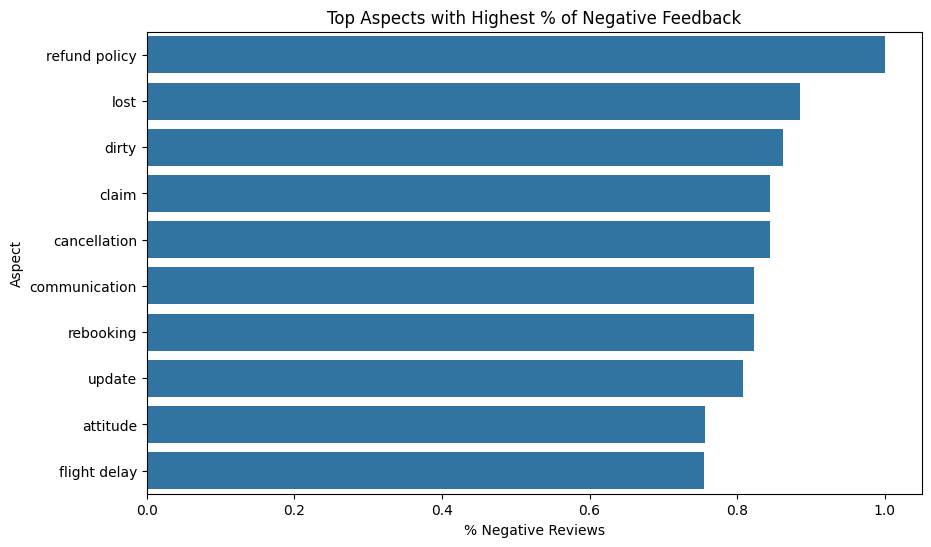

In [32]:
aspect_counts = df.explode('detected_aspects').groupby(['detected_aspects', 'sentiment']).size().unstack(fill_value=0)
aspect_counts['negative_ratio'] = aspect_counts['negative'] / (aspect_counts[['negative', 'positive']].sum(axis=1))

plt.figure(figsize=(10, 6))
sns.barplot(data=aspect_counts.sort_values('negative_ratio', ascending=False).head(10),
            x='negative_ratio', y=aspect_counts.sort_values('negative_ratio', ascending=False).head(10).index)
plt.title("Top Aspects with Highest % of Negative Feedback")
plt.xlabel("% Negative Reviews")
plt.ylabel("Aspect")
plt.show()

In [33]:
# Apply aspect extraction across all reviews
df['detected_aspects'] = df['customer_review'].apply(lambda x: extract_aspects(x, aspects))

# Explode the dataframe so each row has one aspect per review
aspect_sentiment = df.explode('detected_aspects').dropna(subset=['detected_aspects'])

# Group by aspect and sentiment
aspect_counts = aspect_sentiment.groupby(['detected_aspects', 'sentiment']).size().unstack(fill_value=0)

# Add total and negative ratio columns
aspect_counts['total'] = aspect_counts.sum(axis=1)
aspect_counts['negative_ratio'] = aspect_counts['negative'] / aspect_counts['total']
aspect_counts = aspect_counts.sort_values(by='negative_ratio', ascending=False)

# Show top 10 most negatively reviewed aspects
print("Top Aspects by Negative Sentiment Ratio")
print(aspect_counts.head(10))

Top Aspects by Negative Sentiment Ratio
sentiment         negative  neutral  positive  total  negative_ratio
detected_aspects                                                    
lost                   791       76       102    969        0.816305
dirty                  358       27        57    442        0.809955
claim                  348       48        64    460        0.756522
communication          252       37        54    343        0.734694
cancellation           114       22        21    157        0.726115
update                 118       18        28    164        0.719512
rebooking               65       13        14     92        0.706522
attitude               336       48       108    492        0.682927
hygiene                  8        1         3     12        0.666667
flight delay            40        8        13     61        0.655738


In [34]:
!pip install -q transformers torch

In [35]:
from transformers import pipeline, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("yangheng/deberta-v3-base-absa-v1.1")
model = AutoModelForSequenceClassification.from_pretrained("yangheng/deberta-v3-base-absa-v1.1")

tokenizer_config.json:   0%|          | 0.00/372 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/18.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/738M [00:00<?, ?B/s]

In [36]:
# Define function for ABSA
def analyze_aspect_sentiment(review, aspect):
    inputs = tokenizer(f"[CLS] {review} [SEP] {aspect} [SEP]", return_tensors="pt")
    outputs = model(**inputs)
    probs = torch.softmax(outputs.logits, dim=1).detach().numpy()[0]

    sentiment = ["negative", "neutral", "positive"][probs.argmax()]
    return sentiment

In [37]:
random_review = df.iloc[100]['customer_review']
detected_aspects = extract_aspects(random_review, aspects)  # From your existing function

print("Review:", random_review)
for aspect in detected_aspects:
    sentiment = analyze_aspect_sentiment(random_review, aspect)
    print(f"- {aspect}: {sentiment}")

Review: ✅ Trip Verified | Frankfurt to Ankara. Checked in well in advance as I was connecting from an overseas flight. The agent had difficulty locating my reservation despite having been presented with an electronic boarding pass and my passport. At the gate, boarded with the priority group given my status on Star Alliance. On board, the hard product looked good and with the exception of my audio jack the seat functions worked well. Following take off we were offered lunch with two options for main course. The food was tasty for economy class and the portions were OK. Several beverage choices including beer, wine and spirits were offered. The IFE had a glitch where every movie choice was directed to the wrong film each time. The seat was comfortable enough for economy. The flight pushed back and landed on time. I have taken multiple international and domestic flights with TK in recent years and as with my previous flights, this one had passengers standing up and walking to the front o

In [38]:
random_review = df.iloc[20]['customer_review']
detected_aspects = extract_aspects(random_review, aspects)  # From your existing function

print("Review:", random_review)
for aspect in detected_aspects:
    sentiment = analyze_aspect_sentiment(random_review, aspect)
    print(f"- {aspect}: {sentiment}")

Review: ✅ Trip Verified | Kathmandu to Berlin via Istanbul. Their service is worst because they usually overbook the flight and it was like first come first serve basis and airport staff don't even listen the customer request. They treat people like they are doing favor to them. Flight often delayed by 2- 4 hours and they don't care about your connecting flight. In my return flight after issuing boarding pass, my seat plan was changed without any notice and in flight entertainment system is damaged and it was 9 hours long flight. I have requested several times but they don't care and don't give attention to the passengers request.
- service: negative
- notice: negative
- staff: negative
- flight: negative
- entertainment: negative
- boarding: neutral
- seat: negative


In [39]:
random_review = df.iloc[105]['customer_review']
detected_aspects = extract_aspects(random_review, aspects)  # From your existing function

print("Review:", random_review)
for aspect in detected_aspects:
    sentiment = analyze_aspect_sentiment(random_review, aspect)
    print(f"- {aspect}: {sentiment}")

Review: ✅ Trip Verified | Istanbul to Beirut. My flight with Turkish airlines was my worst experience ever. We were a group of 6 people travelling together and it happened that we faced many problems due to the disorganization of the airport and the airline. To start with, we arrived about 2 hours and a half earlier than our flight to the airport. We had to wait like more than half an hour for the passport control due to the congestion, noting that not all counters were available. Then, the staff were shouting on us to remove our shoes and get in the scanner machine and all do not speak English so we had many difficulties to understand what they want. How come that an international airport has only Turkish speaking staff, and rude staff. Next, we went to check in with tax refund process, and here, in this airport happens what does not happen in any airport in the world: They need to check your baggage, you have to open and search for the items in the airport in order to have your invoi